In [37]:
!pip install boto3 numpy nibabel==5.2.1 matplotlib imagemagick


ERROR: Could not find a version that satisfies the requirement imagemagick (from versions: none)
ERROR: No matching distribution found for imagemagick


ERROR: Could not find a version that satisfies the requirement imagemagick (from versions: none)
ERROR: No matching distribution found for imagemagick


Fetching file: BraTS20_Training_369_flair.nii


MovieWriter imagemagick unavailable; using Pillow instead.


Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmp1xssyzax.nii
Data shape for BraTS20_Training_369_flair.nii: (240, 240, 155)
Saving BraTS20_Training_369_flair.nii.gif
Deleted temporary file: C:\Users\zaaim\AppData\Local\Temp\tmp1xssyzax.nii
Fetching file: BraTS20_Training_369_seg.nii


MovieWriter imagemagick unavailable; using Pillow instead.


Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmpr832n35s.nii
Data shape for BraTS20_Training_369_seg.nii: (240, 240, 155)
Saving BraTS20_Training_369_seg.nii.gif
Deleted temporary file: C:\Users\zaaim\AppData\Local\Temp\tmpr832n35s.nii
Fetching file: BraTS20_Training_369_t1.nii


MovieWriter imagemagick unavailable; using Pillow instead.


Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmp3m0uhi20.nii
Data shape for BraTS20_Training_369_t1.nii: (240, 240, 155)
Saving BraTS20_Training_369_t1.nii.gif
Deleted temporary file: C:\Users\zaaim\AppData\Local\Temp\tmp3m0uhi20.nii
Fetching file: BraTS20_Training_369_t1ce.nii


MovieWriter imagemagick unavailable; using Pillow instead.


Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmp6atgb70e.nii
Data shape for BraTS20_Training_369_t1ce.nii: (240, 240, 155)
Saving BraTS20_Training_369_t1ce.nii.gif
Deleted temporary file: C:\Users\zaaim\AppData\Local\Temp\tmp6atgb70e.nii
Fetching file: BraTS20_Training_369_t2.nii


MovieWriter imagemagick unavailable; using Pillow instead.


Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmpltvtzrgj.nii
Data shape for BraTS20_Training_369_t2.nii: (240, 240, 155)
Saving BraTS20_Training_369_t2.nii.gif
Deleted temporary file: C:\Users\zaaim\AppData\Local\Temp\tmpltvtzrgj.nii


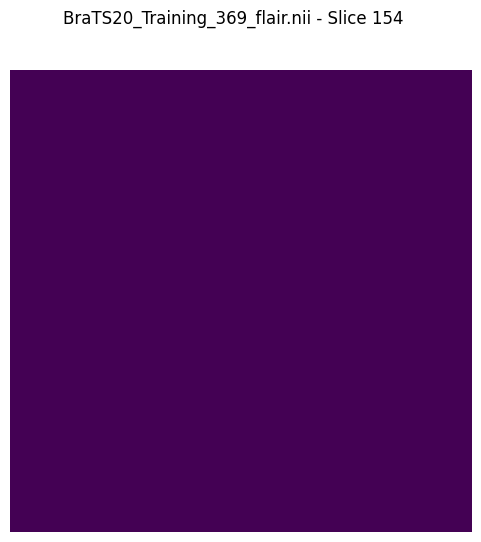

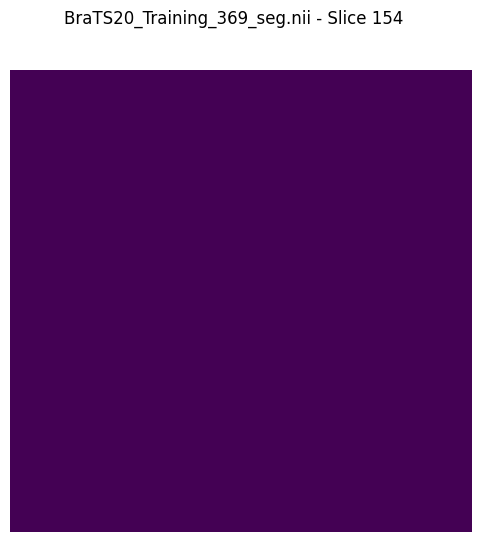

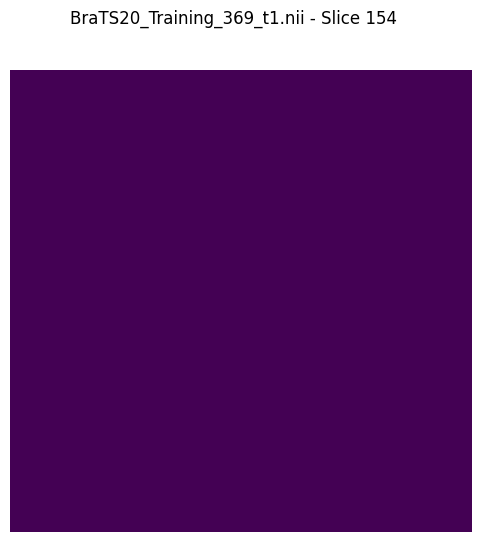

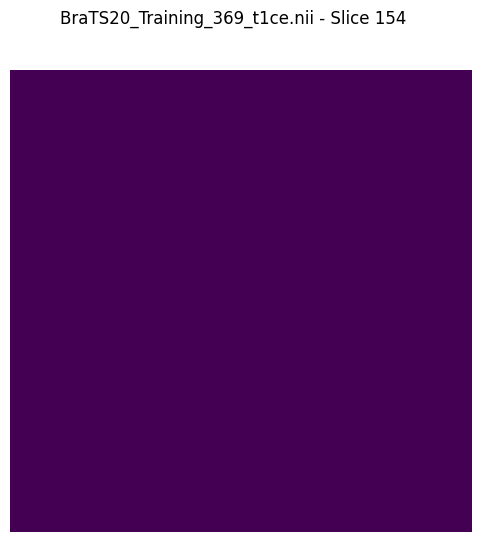

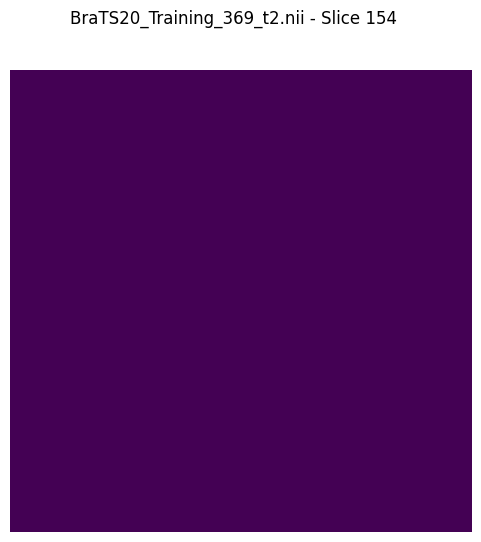

In [47]:

import boto3
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import io
import tempfile
import os
from IPython.display import Image

s3 = boto3.resource('s3')
bucket_name = 'chemocraft-data'
folder_path = 'Data/BraTS20_Training_369 copy/'
bucket = s3.Bucket(bucket_name)

visualizer_folder = 'brain_visualizations'

def render_nii_from_s3(filename):
    print(f"Fetching file: {filename}")

    obj = bucket.Object(folder_path + filename)
    file_stream = io.BytesIO(obj.get()['Body'].read())

    with tempfile.NamedTemporaryFile(suffix='.nii', delete=False) as temp_file:  # Disable auto-delete
        temp_file.write(file_stream.getvalue())
        temp_file.flush()

        temp_file_path = temp_file.name
        print(f"Temporary file created: {temp_file_path}")

    try:
        img = nib.load(temp_file_path)
        data = img.get_fdata()

        print(f"Data shape for {filename}: {data.shape}")

        if data.size == 0:
            print(f"No data found in {filename}")
            return

        #slice_idx = data.shape[2] // 2 

        slice_idx = 88

        fig, ax = plt.subplots(figsize=(6, 6))
        imgdisplay = ax.imshow(data[:, :, slice_idx])
        fig.suptitle(f'{filename} - Slice {slice_idx}')
        plt.axis('off')  # Hide axes for cleaner display

        def update(frame):
            if frame<0 or frame>=data.shape[2]:
                return imgdisplay

            imgdisplay.set_data(data[:, :, frame])
            imgdisplay.figure.suptitle(f'{filename} - Slice {frame}')
            return imgdisplay

        ani = animation.FuncAnimation(fig=fig, func=update, frames=155, interval=50)
        print(f"Saving {filename}.gif")
        vid_path = os.path.join(visualizer_folder, f"video_{filename.split(".")[0]}.gif");
        ani.save(vid_path, writer="imagemagick")

    except Exception as e:
        print(f"Error loading file {filename}: {e}")
    finally:
        try:
            os.remove(temp_file_path)  # Clean up the temp file
            print(f"Deleted temporary file: {temp_file_path}")
        except OSError as cleanup_error:
            print(f"Error deleting temp file: {cleanup_error}")

found_files = False
for obj in bucket.objects.filter(Prefix=folder_path):
    if obj.key.endswith('.nii'):
        found_files = True
        filename = obj.key.split('/')[-1]  # Get the filename
        render_nii_from_s3(filename)

if not found_files:
    print(f"No .nii files found in the folder {folder_path}")




In [16]:
!pip show nibabel numpy boto3

Name: nibabel
Version: 5.2.1
Summary: Access a multitude of neuroimaging data formats
Home-page: https://nipy.org/nibabel
Author: 
Author-email: NiBabel developers <neuroimaging@python.org>
License: MIT License
Location: C:\Users\zaaim\anaconda3\envs\myenv\Lib\site-packages
Requires: numpy, packaging
Required-by: 
---
Name: numpy
Version: 2.1.2
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the docum